In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import proplot as pplot
import matplotlib.pyplot as plt
import cmaps
import cnmaps

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import transform
from cnmaps import get_map, draw_map, clip_contours_by_map
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.patches import Rectangle

from scipy.stats import linregress
from shapely.geometry import mapping

import os
os.chdir('/Users/zeqinhuang/Documents/paper/HW_track')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# data for drawing South China sea
with open('shapefiles/CN-border-L1.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]

river = shpreader.Reader('shapefiles/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.3)
city_agg = shpreader.Reader('shapefiles/urban_agg_wgs84.shp')
city_feature = ShapelyFeature(city_agg.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.5)

In [3]:
def _compute_slope(var):
    """
    Private function to compute slopes at each grid cell using
    linregress. 
    """
    slp = linregress(range(len(var)),var).slope
    return slp

def _compute_sig(var):
    """
    Private function to compute slopes at each grid cell using
    linregress. 
    """
    sig = linregress(range(len(var)),var).pvalue
    if sig < 0.05:
        sig = 1
    else:
        sig = 0
    return sig

def trend_cal(data):
    """
    Computes linear slope (m) at each grid cell.
    Args:
        da: xarray DataArray to compute slopes for
    Returns:
        xarray DataArray with slopes computed at each grid cell.
    """
    slopes = xr.apply_ufunc(_compute_slope,
                            data,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    sig = xr.apply_ufunc(_compute_sig,
                            data,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes,sig

In [33]:
SAT_summer_1979_2022 = xr.open_dataarray('data/t2m_summer_1979_2022.nc')
SAT_summer_trend,SAT_summer_sig = trend_cal(SAT_summer_1979_2022)

HWD_summer_1979_2022 = xr.open_dataarray('data/hwd_summer_1979_2022.nc')
HWD_summer_trend,HWD_summer_sig = trend_cal(HWD_summer_1979_2022)

HWL_summer_1979_2022 = xr.open_dataarray('data/hwl_summer_1979_2022.nc')
HWL_summer_trend,HWL_summer_sig = trend_cal(HWL_summer_1979_2022)

HWM_summer_1979_2022 = xr.open_dataarray('data/hwm_summer_1979_2022.nc')
HWM_summer_1979_2022 = HWM_summer_1979_2022.fillna(value=0)
HWM_summer_trend,HWM_summer_sig = trend_cal(HWM_summer_1979_2022)

In [6]:
from descartes import PolygonPatch
import shapefile
from copy import copy
import matplotlib.path as mpath
import matplotlib.patches as mpatches
source_path = 'shapefiles/country.shp'

Path = mpath.Path
sfile = shapefile.Reader(source_path)
for shape_rec in sfile.shapeRecords():
    vertices = []
    codes = []
    pts = shape_rec.shape.points
    prt = list(shape_rec.shape.parts) + [len(pts)]
    for i in range(len(prt) - 1):
        for j in range(prt[i], prt[i+1]):
            vertices.append((pts[j][0], pts[j][1]))
        codes += [Path.MOVETO]
        codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
        codes += [Path.CLOSEPOLY]
    clip = mpath.Path(vertices, codes)
    clip = mpatches.PathPatch(clip,visible=False,transform=ccrs.PlateCarree())

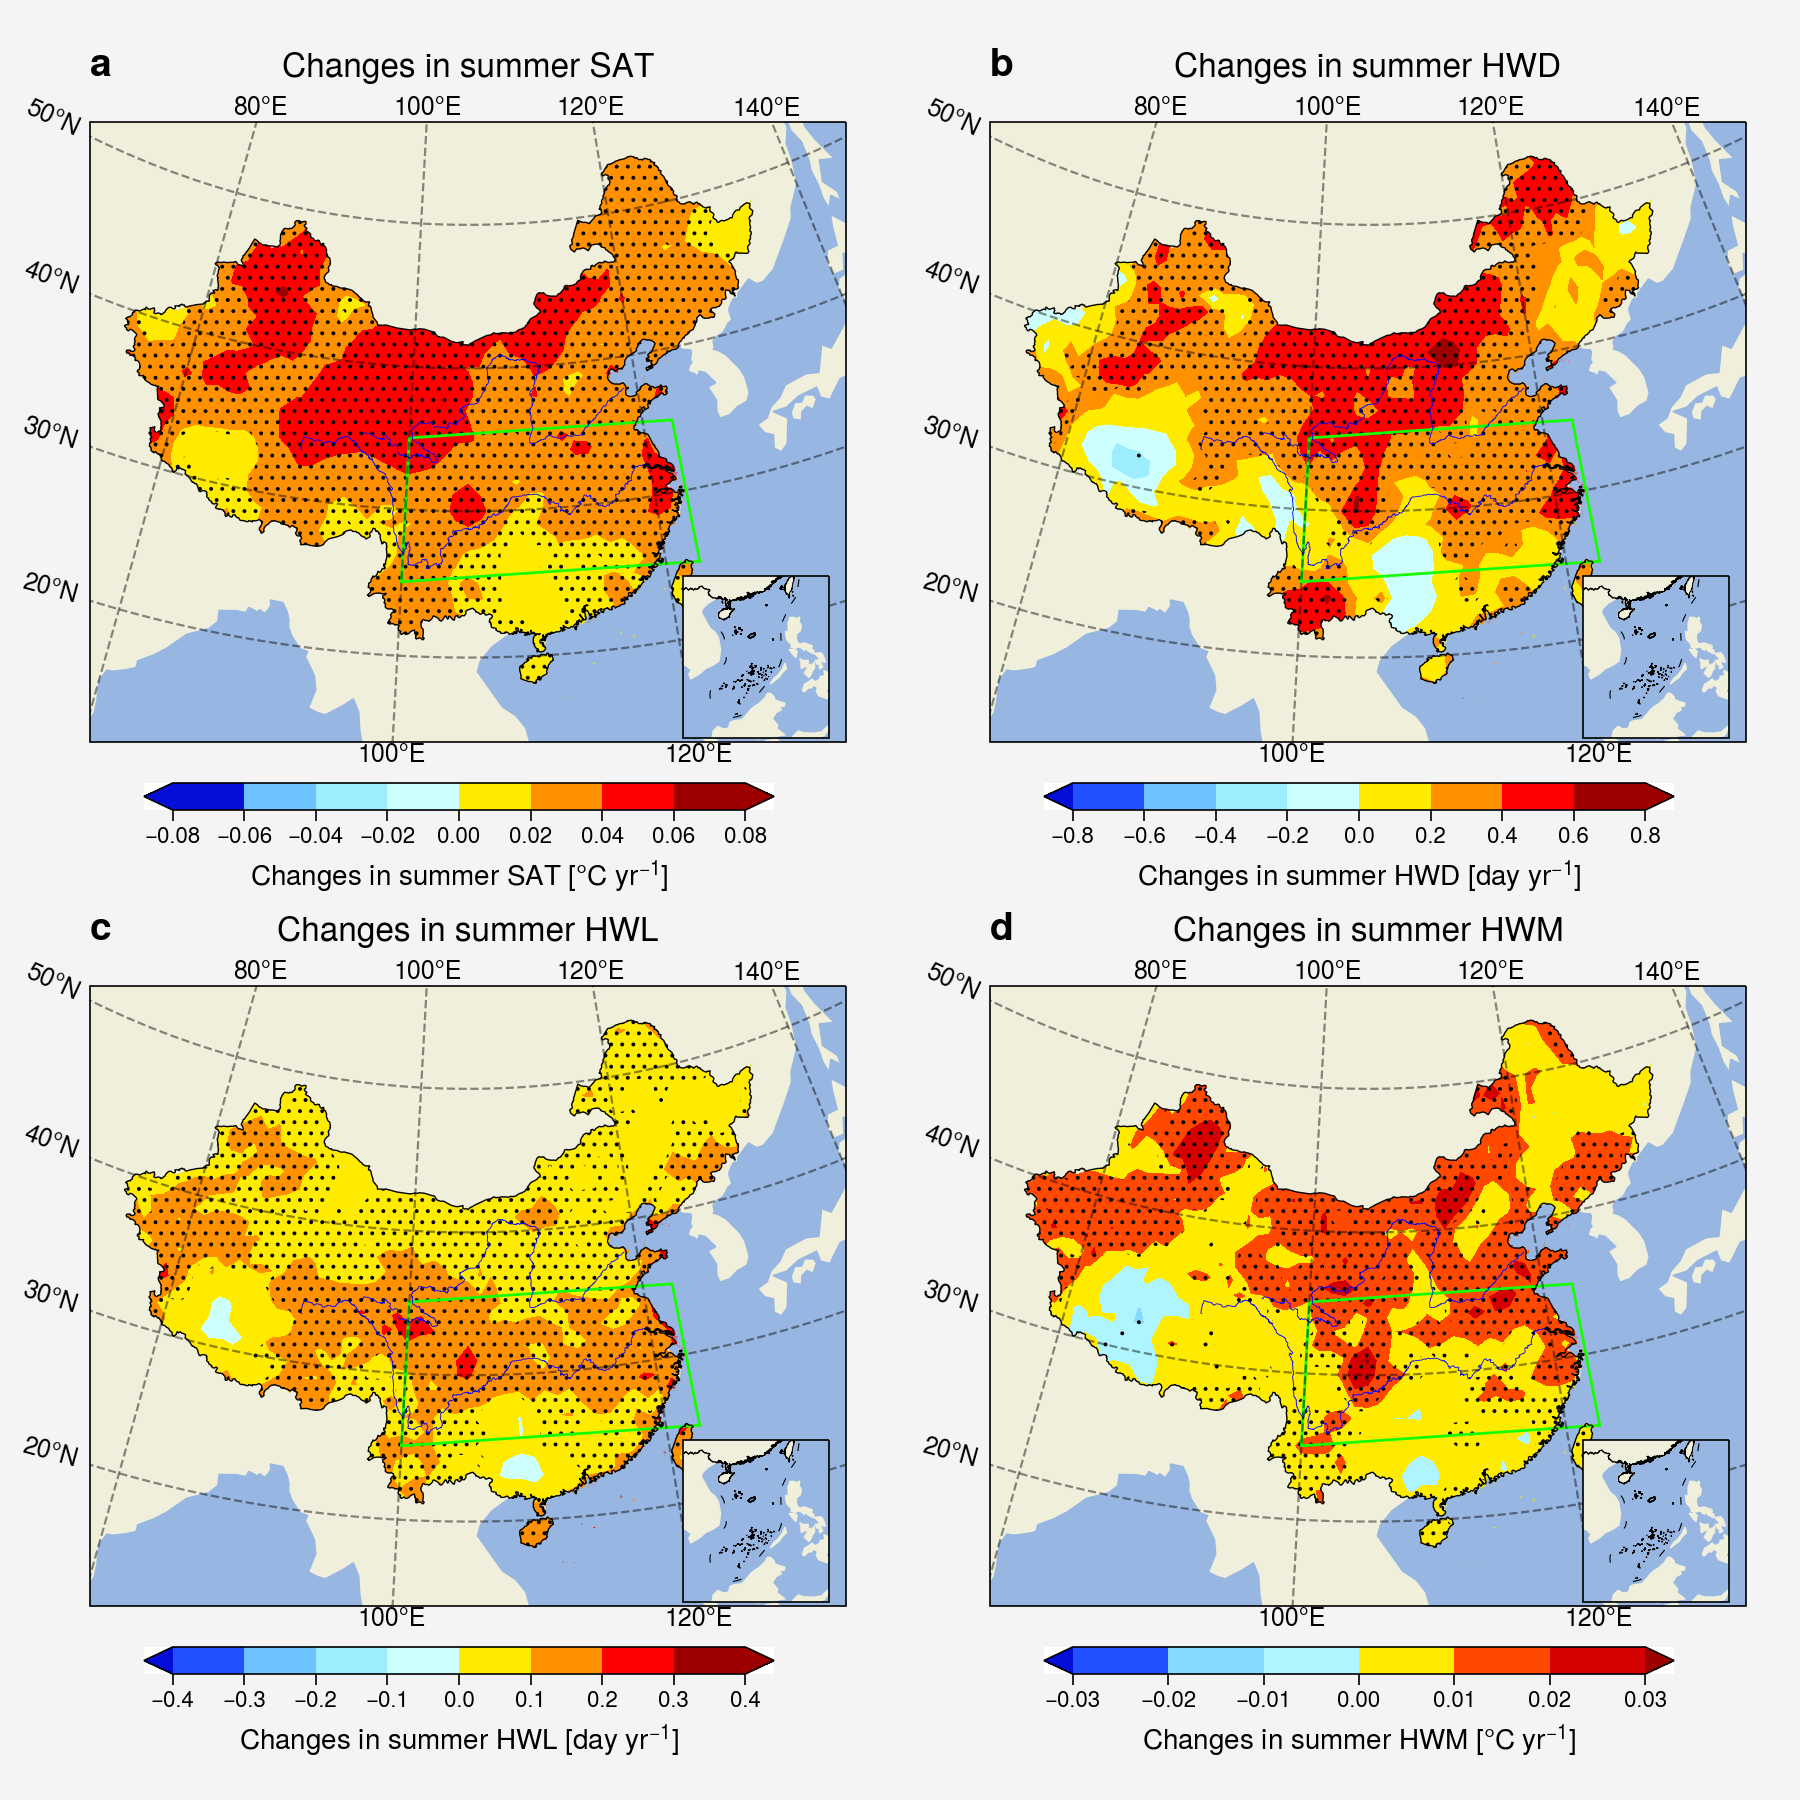

In [40]:
axes_locs = [
    [0.05,0.56,0.42,0.4],
    [0.55,0.56,0.42,0.4],
    [0.05,0.08,0.42,0.4],
    [0.55,0.08,0.42,0.4],
]
cbar_locs = [
    [0.08, 0.55, 0.35, 0.015],
    [0.58, 0.55, 0.35, 0.015],
    [0.08, 0.07, 0.35, 0.015],
    [0.58, 0.07, 0.35, 0.015],
]
sub_axes_locs = [
    [0.375, 0.59, 0.09, 0.09],
    [0.875, 0.59, 0.09, 0.09],
    [0.375, 0.11, 0.09, 0.09],
    [0.875, 0.11, 0.09, 0.09]
]

fig = plt.figure(figsize = (9,9))

# ax1 for SAT anomalies
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
ax1 = fig.add_axes(axes_locs[0], projection = mapcrs)
ax1.add_feature(cfeature.LAND.with_scale('110m'))
ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
ax1.add_feature(river_feature)
ax1.set_extent([80, 130, 13, 55])
ax1.set_title('Changes in summer SAT',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.05)
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)
sub_ax = fig.add_axes(sub_axes_locs[0], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

lon = SAT_summer_trend['longitude']
lat = SAT_summer_trend['latitude']
clip_copy = copy(clip)
ax1.add_patch(clip_copy)
p2 = ax1.contourf(lon, lat, SAT_summer_trend, cmap=cmaps.GMT_panoply, levels=[-0.08,-0.06,-0.04,-0.02,0,0.02,0.04,0.06,0.08],extend = 'both', transform=ccrs.PlateCarree()) #vmin=-4, vmax=4,
p3 = ax1.contourf(
    lon, lat, SAT_summer_sig,
    transform=ccrs.PlateCarree(),
    colors='none',
    edgecolor='gray',
    levels=[.5, 1.5],
    hatches=['...',None],
    linewidth=2
)
ax1.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
for c in p2.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)
for c in p3.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

cbar_ax = fig.add_axes(cbar_locs[0])
fig_cbar = fig.colorbar(p2, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('Changes in summer SAT [°C yr$^{-1}$]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl2 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl2.xlabel_style = {'rotation': 0, 'ha':'center'}
gl2.right_labels = False

# ax2 for HWD anomalies
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
ax2 = fig.add_axes(axes_locs[1], projection = mapcrs)
ax2.add_feature(cfeature.LAND.with_scale('110m'))
ax2.add_feature(cfeature.OCEAN.with_scale('110m'))
ax2.add_feature(river_feature)
ax2.set_extent([80, 130, 13, 55])
ax2.set_title('Changes in summer HWD',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.05)
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)
sub_ax = fig.add_axes(sub_axes_locs[1], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

lon = HWD_summer_trend['longitude']
lat = HWD_summer_trend['latitude']
clip_copy = copy(clip)
ax2.add_patch(clip_copy)
p2 = ax2.contourf(lon, lat, HWD_summer_trend, cmap=cmaps.GMT_panoply, levels=[-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8],extend = 'both', transform=ccrs.PlateCarree()) #vmin=-4, vmax=4,
p3 = ax2.contourf(
    lon, lat, HWD_summer_sig,
    transform=ccrs.PlateCarree(),
    colors='none',
    edgecolor='gray',
    levels=[.5, 1.5],
    hatches=['...',None],
    linewidth=2
)

ax2.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
for c in p2.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)
for c in p3.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

cbar_ax = fig.add_axes(cbar_locs[1])
fig_cbar = fig.colorbar(p2, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('Changes in summer HWD [day yr$^{-1}$]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl2.xlabel_style = {'rotation': 0, 'ha':'center'}
gl2.right_labels = False

# ax3 for HWL anomalies
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
ax3 = fig.add_axes(axes_locs[2], projection = mapcrs)
ax3.add_feature(cfeature.LAND.with_scale('110m'))
ax3.add_feature(cfeature.OCEAN.with_scale('110m'))
ax3.add_feature(river_feature)
ax3.set_extent([80, 130, 13, 55])
ax3.set_title('Changes in summer HWL',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.05)
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)
sub_ax = fig.add_axes(sub_axes_locs[2], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

lon = HWL_summer_trend['longitude']
lat = HWL_summer_trend['latitude']
clip_copy = copy(clip)
ax3.add_patch(clip_copy)
p2 = ax3.contourf(lon, lat, HWL_summer_trend, cmap=cmaps.GMT_panoply, levels=[-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4],extend = 'both', transform=ccrs.PlateCarree()) #vmin=-4, vmax=4,
p3 = ax3.contourf(
    lon, lat, HWL_summer_sig,
    transform=ccrs.PlateCarree(),
    colors='none',
    edgecolor='gray',
    levels=[.5, 1.5],
    hatches=['...',None],
    linewidth=2
)

ax3.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
for c in p2.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)
for c in p3.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

cbar_ax = fig.add_axes(cbar_locs[2])
fig_cbar = fig.colorbar(p2, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('Changes in summer HWL [day yr$^{-1}$]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl2 = ax3.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl2.xlabel_style = {'rotation': 0, 'ha':'center'}
gl2.right_labels = False

# ax4 for HWM anomalies
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
ax4 = fig.add_axes(axes_locs[3], projection = mapcrs)
ax4.add_feature(cfeature.LAND.with_scale('110m'))
ax4.add_feature(cfeature.OCEAN.with_scale('110m'))
ax4.add_feature(river_feature)
ax4.set_extent([80, 130, 13, 55])
ax4.set_title('Changes in summer HWM',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.05)
china = get_map('中国')
draw_map(china,color='black',linewidth=0.5)
sub_ax = fig.add_axes(sub_axes_locs[3], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
for line in borders:
    sub_ax.plot(line[0::2], line[1::2], '-', color='black',transform=ccrs.Geodetic(),linewidth=0.4)
sub_ax.set_extent([105, 125, 0, 25])

lon = HWM_summer_trend['longitude']
lat = HWM_summer_trend['latitude']
clip_copy = copy(clip)
ax4.add_patch(clip_copy)
p2 = ax4.contourf(lon, lat, HWM_summer_trend, cmap=cmaps.GMT_panoply, levels=[-0.03,-0.02,-0.01,0,0.01,0.02,0.03],extend = 'both', transform=ccrs.PlateCarree()) #vmin=-4, vmax=4,
p3 = ax4.contourf(
    lon, lat, HWM_summer_sig,
    transform=ccrs.PlateCarree(),
    colors='none',
    edgecolor='gray',
    levels=[.5, 1.5],
    hatches=['...',None],
    linewidth=2
)

ax4.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,transform=ccrs.PlateCarree()))
for c in p2.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)
for c in p3.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

cbar_ax = fig.add_axes(cbar_locs[3])
fig_cbar = fig.colorbar(p2, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=8)
fig_cbar.set_label('Changes in summer HWM [°C yr$^{-1}$]',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl2 = ax4.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
gl2.xlabel_style = {'rotation': 0, 'ha':'center'}
gl2.right_labels = False

def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,fontsize=14, fontweight='bold', va='top', ha='left')
add_panel_label(ax1, 'a', x=0, y = 1.12)
add_panel_label(ax2, 'b', x=0, y = 1.12)
add_panel_label(ax3, 'c', x=0, y = 1.12)
add_panel_label(ax4, 'd', x=0, y = 1.12)

plt.tight_layout()
plt.savefig("Figures/FigS1_heatwave_changes2.pdf",bbox_inches='tight')
plt.savefig('Figures/FigS1_heatwave_changes2.png',bbox_inches='tight')